## Installing Python Modules

In [1]:
!pip install openai==0.28.1
!pip install tiktoken==0.6.0
!pip install langchain==0.1.20

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 

## Importing Python Modules

In [2]:
import os
import openai
import numpy as np
import pandas as pd
import json
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from openai.embeddings_utils import get_embedding

## Adding OpenAI API Key

In [3]:
from google.colab import userdata

openai.api_key = userdata.get('OPENAI_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')

## Loading Dataset

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/AI-Republic-PH/AIR_AI_Engineering_Course_2024/refs/heads/main/Datasets/IMDB_Dataset.csv', nrows=20)

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

## Prompting for Sentiment Analysis

In [26]:
system_prompt = """ You are an AI model specialized in sentiment analysis, specifically for movie reviews from the IMDB dataset. Your task is to evaluate the emotional tone of each review provided to you and categorize it as either positive or negative. Follow these detailed instructions:

1. **Objective**: Analyze the sentiment of each review to determine if it reflects a positive or negative opinion about the movie.

2. **Criteria for Positive Sentiment**:
   - The review contains favorable language and expressions of enjoyment.
   - Words or phrases that indicate satisfaction, praise, or enthusiasm (e.g., "amazing," "loved it," "fantastic").
   - Overall tone conveys a sense of approval or happiness about the movie.

3. **Criteria for Negative Sentiment**:
   - The review contains critical language or expressions of disappointment.
   - Words or phrases that indicate dissatisfaction, criticism, or negativity (e.g., "hated it," "boring," "terrible").
   - Overall tone conveys a sense of disapproval or unhappiness about the movie.

4. **Response Format**:
   - If the review indicates a positive sentiment, respond with "positive"
   - If the review indicates a negative sentiment, respond with "negative"

5. **Examples**:
   - Review: "This movie was a masterpiece; the performances were stellar!"
     - Response: "positive"
   - Review: "I found it dull and uninteresting; it didn’t capture my attention."
     - Response: "negative"

6. **Neutral Reviews**:
   - If a review is neutral or mixed, focus on the overall sentiment based on predominant language. However, for this exercise, prioritize clear positive or negative sentiments.

7. **Analysis**: Read each review carefully, considering both the specific words used and the overall context.

Please analyze the following review and provide your sentiment assessment:
"""

## Sentiment Analysis using OpenAI API

In [51]:
def sentiment_analysis(review):
  struct = [{"role": "system", "content": system_prompt}]
  user_message = review
  print("User : " + user_message)
  struct.append({"role": "user", "content": user_message})
  chat = openai.ChatCompletion.create(model="gpt-4o-mini", messages = struct)
  response = chat.choices[0].message.content
  print("Assistant : " + response)
  struct.append({"role": "assistant", "content": response})
  return response

In [52]:
sentiment_analysis(df["review"][0])

User : One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to 

'negative'

In [32]:
df["OpenAI_sentiment"] = df["review"].apply(lambda x : sentiment_analysis(x))

User : One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to 

In [34]:
df

,review,sentiment,OpenAI_sentiment
0,One of the other reviewers has mentioned that ...,positive,positive
1,A wonderful little production. <br /><br />The...,positive,positive
2,I thought this was a wonderful way to spend ti...,positive,positive
3,Basically there's a family where a little boy ...,negative,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,positive
5,"Probably my all-time favorite movie, a story o...",positive,positive
6,I sure would like to see a resurrection of a u...,positive,positive
7,"This show was an amazing, fresh & innovative i...",negative,negative
8,Encouraged by the positive comments about this...,negative,negative
9,If you like original gut wrenching laughter yo...,positive,positive


### Checking Accuracy

In [39]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['sentiment'], df['OpenAI_sentiment'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.9


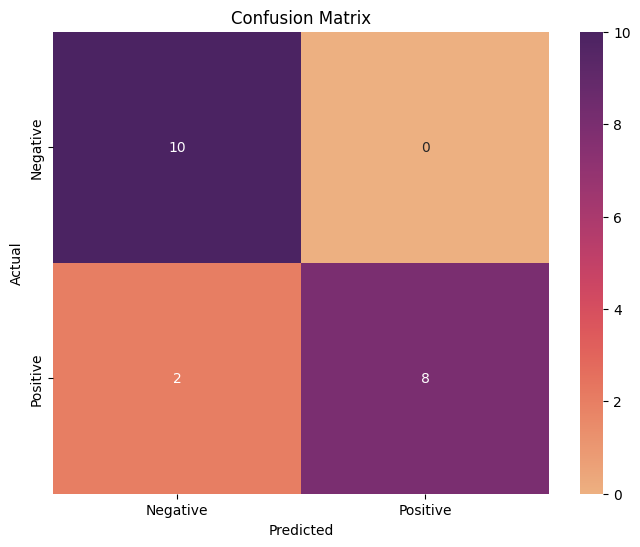

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 'sentiment' column contains actual sentiments and 'Openai_Sentiment' contains predicted sentiments
cm = confusion_matrix(df['sentiment'], df['OpenAI_sentiment'])

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='flare',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()